In [1]:
import HM2_functions as hm

In [2]:
import pandas as pd
import seaborn 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
from matplotlib.ticker import PercentFormatter

pd.options.display.min_rows = 99999


In [3]:
# directory paths for the DataFrames
l = ['/Users/paolaantonicoli/2019-Oct.csv',
     '/Users/paolaantonicoli/2019-Nov.csv',
     '/Users/paolaantonicoli/2019-Dec.csv',
     '/Users/paolaantonicoli/2020-Jan.csv',
     '/Users/paolaantonicoli/2020-Feb.csv',
     '/Users/paolaantonicoli/2020-Mar.csv',
    '/Users/paolaantonicoli/2020-Apr.csv',]


 #  Introduction
 


> **PRELIMINARY REMARKS**

The database we're going to analyze contains user behaviour data from an online store in the period from October 2019 to April 2020. We thought it wasn't necessary to perform a preliminary data cleansing: data are very numerous and meaningful, and the only missing informations (NaN values) concern category_code and brand fields (which are strings), and they don't allow to infer very much about the nature of a purchase; they only do it indirectly on the basis of the product's price.
Because of the very high number of rows, for the data analysis we preferred working with chunks, namely subsets of the .csv files, summarizing the relevant informations in small dataframes that we joined together later in order to provide the desired outcomes.






In [8]:
hm.info_list(l)


-------------------October-------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   event_time     42448764 non-null  object 
 1   event_type     42448764 non-null  object 
 2   product_id     42448764 non-null  int64  
 3   category_id    42448764 non-null  int64  
 4   category_code  28933155 non-null  object 
 5   brand          36331684 non-null  object 
 6   price          42448764 non-null  float64
 7   user_id        42448764 non-null  int64  
 8   user_session   42448762 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB
None

-------------------November------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     ----- 

_______________
# RQ 1
*A marketing funnel describes your customer’s journey with your e-commerce. It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond. Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase. Which is the rate of complete funnels?*

This research question requires an analysis of the actions that are performed in the online store. In particular, it can be shown that inside the database there are 3 types of actions that can be performed by users:



In [5]:
hm.main_event_type(l)

0        view
1    purchase
2        cart
Name: event_type, dtype: object

> ### **[RQ 1.1]** 
*What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).*

In [4]:
result_1_1 = hm.RQ_1_1(l)
result_1_1

,event_type,number_of_events,avg_number_of_times
0,cart,19113931,0.213103
1,purchase,6848820,0.076358
2,view,385746759,4.300717


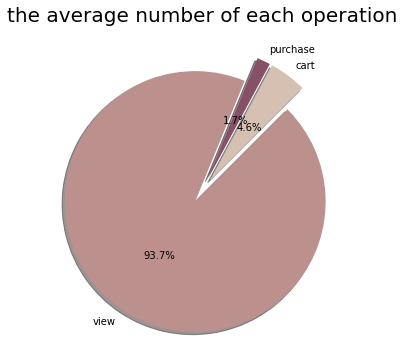

In [8]:
hm.plot_RQ_1_1(result_1_1)

It can be seen that 'view'  accounts for the biggest percentage of operations made by users, while 'cart' and 'purchase' make up only a small percentage. This result could be expected, because the simple act of viewing a product is the operation that requires the lowest amount of commitment from users, especially the indecisive ones.

> ### **[RQ 1.2]**                  
*How many times, on average, a user views a product before adding it to the cart?*


Even though it looks simple at first sight, the implementation of this query is quite complex, due to the very high quantity of data inside the database. Distinguishing between views before and after a certain addition to cart requires that for each product added to cart by each user there is a time comparison with every view of this product by this user. 
This analysis does not fully support a partition in chunks, because then it would be impossible to make a comparison if a view and an addition to cart of the same product by the same user are in two different chunks.
Our initial strategy consisted in dividing the database in groups containing each one the additions to cart of a certain product made by a certain user. The strategy continued with computing the cartesian product of each one of this groups with the database containing only the views of that product by that user, and then removing all the views subsequent to an addition to cart. However,  this method turned out too much computationally expensive, due to very high number of 'view' events.
For this reason we preferred to use a simpler, much faster algorithm that counts all the views of a certain product by a certain user, including the ones subsequent to addition to cart operations. We think this result, despite not being exactly equal to the required result, is still significant for the purposes of the qualitative analysis that we want to make.


In [4]:
result_1_2 = hm.RQ_1_2(l)
result_1_2

5.96031099681205

> ### **[RQ 1.3]**  
*What’s the probability that products added once to the cart are effectively bought?*


In this case we intepreted the concept of  "probability" as the parameter *p* of a Bernoulli over *X* belonging to {0,1}, where X=1 if a product is purchased and X=0 if a product is not purchased. We decided to estimate this parameter according to a frequentist framework, as the ratio between the number of purchased products (that were added to the cart) and the total number of products added to the cart.

In [5]:
result_1_3 = hm.RQ_1_3(l)
result_1_3

0.46303297361722673

> ### **[RQ 1.4]**  
*What’s the average time an item stays in the cart before being removed?*


Since the "remove_from_cart" event was not present in the database we interpreted "being removed" as "being purchased". We extracted two dataframe from the database, one contatining all the additons to cart, grouped by user_id and product_id, and the other one containing the first purchase of each product by each user.With a pandas merge operation we obtained a dataframe in which each row contains information about both an addition to cart and the first purchase of each product by each user (one row for each addition to cart). We then computed the time difference using our function time_difference, eliminating all negative time differences (indicating an addition to cart occurring after the first purchase). The parsing operation on the 'event_time' field, necessary to compute the time difference, was computed only on the relevant rows, in order to spare computational time.

In [3]:
df_1_4 = hm.cart_removed(l)
df_1_4

,purchasing_time,user_session,product_id,carting_time,time_diff
0,2019-10-01 00:10:08 UTC,0b74a829-f9d7-4654-b5b0-35bc9822c238,1002524,2019-10-01 00:09:33 UTC,00:00:35
1,2019-10-01 02:21:02 UTC,d068d08f-aaf3-4949-b031-cdaf49a5c7cf,1004659,2019-10-01 02:20:44 UTC,00:00:18
2,2019-10-01 02:22:11 UTC,ce885079-4d92-4fe6-92a3-377c5a2d8291,1004750,2019-10-01 02:19:43 UTC,00:02:28
3,2019-10-01 02:22:29 UTC,63de1120-9d48-45d0-b024-500d1b95d71f,1500021,2019-10-01 02:21:04 UTC,00:01:25
4,2019-10-01 02:22:29 UTC,63de1120-9d48-45d0-b024-500d1b95d71f,1500021,2019-10-01 02:21:33 UTC,00:00:56
...,...,...,...,...,...
8795536,2020-04-30 23:59:03 UTC,36b0e662-5456-4dac-9ab1-b8c7245dbbd2,1004226,2020-04-30 23:55:24 UTC,00:03:39
8795537,2020-04-30 23:59:32 UTC,a48325b5-a58c-4016-a876-8fe6c9b7dfec,4802161,2020-04-30 23:59:11 UTC,00:00:21
8795538,2020-04-30 23:59:36 UTC,9b370ac6-6655-40c4-90f0-e5d6917b8959,100143638,2020-04-30 23:57:45 UTC,00:01:51
8795539,2020-04-30 23:59:36 UTC,9b370ac6-6655-40c4-90f0-e5d6917b8959,100143638,2020-04-30 23:57:51 UTC,00:01:45


In [6]:
result_1_4 = hm.time_diff.mean()
result_1_4

Timedelta('0 days 02:03:43.860598')

> ### **[RQ 1.5]** 
*How much time passes on average between the first view time and a purchase/addition to cart?*


Our strategy is analogous to the one of the previous research question: we extracted two dataframes from the database, one contatining the first view of  each product by each user, and the other one containing, for each product and for each user, the first event between a purchase and an addition to cart. With a pandas merge operation we obtained a dataframe in which each row contains information about both the first view and the first purchase or addition to cart of each product by each user. We then computed the time difference using our function time_difference. The parsing operation on the 'event_time' field, necessary to compute the time difference, was computed only on the relevant rows, in order to spare computational time. However, the computation was still unfeasible, so we produced an approximate result (since it does not take into account the case in which the first view of a certain product by a certain user happens in a month and the first purchase/addition to cart in a subsequent month).
Moreover it would be intresting evaluate if the changes of impulsivness of the users according to the period of the year, for example during holidays,it's easy to suppose that the time that occurs between the first view and the purchase results to be shorter.
On the contrary during this particular year, the time was shorter during February and March; we think that this is linked to the Quarantine due to the outbreak of the Pandemic.


In [9]:
df_1_5_Oct=hm.time_first_view_and_pur_cart(l[0:1])
df_1_5_Oct

,carting_purchasing_time,user_id,product_id,view_time,time_diff
0,2019-10-01 00:02:14 UTC,543272936,1004856,2019-10-01 00:01:46 UTC,0 days 00:00:28
1,2019-10-04 14:36:06 UTC,543272936,1004856,2019-10-01 00:01:46 UTC,3 days 14:34:20
2,2019-10-01 00:04:37 UTC,551377651,1002532,2019-10-01 00:02:47 UTC,0 days 00:01:50
3,2019-10-01 00:05:14 UTC,550121407,5100816,2019-10-01 00:04:47 UTC,0 days 00:00:27
4,2019-10-01 00:06:02 UTC,514591159,5100816,2019-10-01 00:04:02 UTC,0 days 00:02:00
...,...,...,...,...,...
1056752,2019-10-31 23:55:13 UTC,516604399,26402784,2019-10-31 23:51:52 UTC,0 days 00:03:21
1056753,2019-10-31 23:55:21 UTC,514622109,47500017,2019-10-31 23:53:17 UTC,0 days 00:02:04
1056754,2019-10-31 23:56:11 UTC,533892594,1004240,2019-10-18 22:45:48 UTC,13 days 01:10:23
1056755,2019-10-31 23:56:53 UTC,533892594,1004240,2019-10-18 22:45:48 UTC,13 days 01:11:05


In [11]:
df_1_5_Oct.time_diff.mean()

Timedelta('1 days 01:32:04.903675')

In [12]:
df_1_5_Nov=hm.time_first_view_and_pur_cart(l[1:2])
df_1_5_Nov

,carting_purchasing_time,user_id,product_id,view_time,time_diff
2,2019-11-01 00:01:04 UTC,513351129,1005161,2019-11-01 00:00:17 UTC,00:00:47
3,2019-11-01 00:03:24 UTC,557746614,1801881,2019-11-01 00:02:56 UTC,00:00:28
4,2019-11-01 00:06:33 UTC,557746614,1801881,2019-11-01 00:02:56 UTC,00:03:37
5,2019-11-01 00:03:39 UTC,565865924,1005115,2019-11-01 00:03:11 UTC,00:00:28
6,2019-11-01 00:04:51 UTC,562958505,1004856,2019-11-01 00:04:31 UTC,00:00:20
...,...,...,...,...,...
2342449,2019-11-30 23:58:42 UTC,575086722,22700202,2019-11-30 23:54:05 UTC,00:04:37
2342450,2019-11-30 23:58:55 UTC,543733099,3701309,2019-11-30 23:46:26 UTC,00:12:29
2342451,2019-11-30 23:59:15 UTC,543733099,3701309,2019-11-30 23:46:26 UTC,00:12:49
2342452,2019-11-30 23:59:26 UTC,576652951,33000529,2019-11-30 23:57:24 UTC,00:02:02


In [13]:
df_1_5_Nov.time_diff.mean()

Timedelta('1 days 01:41:51.447810')

In [14]:
df_1_5_Dec=hm.time_first_view_and_pur_cart(l[2:3])
df_1_5_Dec

,carting_purchasing_time,user_id,product_id,view_time,time_diff
1,2019-12-01 17:21:00 UTC,535135317,26400248,2019-12-01 00:00:23 UTC,0 days 17:20:37
5,2019-12-02 14:57:37 UTC,550465671,17800342,2019-12-01 00:00:38 UTC,1 days 14:56:59
6,2019-12-01 00:00:30 UTC,555295228,1005003,2019-12-01 00:00:19 UTC,0 days 00:00:11
7,2019-12-01 00:02:01 UTC,555295228,1005003,2019-12-01 00:00:19 UTC,0 days 00:01:42
8,2019-12-01 00:00:39 UTC,543733099,3701309,2019-12-01 00:00:06 UTC,0 days 00:00:33
...,...,...,...,...,...
2642493,2019-12-31 23:56:57 UTC,516782548,1004250,2019-12-31 23:56:51 UTC,0 days 00:00:06
2642494,2019-12-31 23:58:06 UTC,520516179,100015992,2019-12-31 23:44:35 UTC,0 days 00:13:31
2642495,2019-12-31 23:58:28 UTC,592177750,1005169,2019-12-31 23:58:16 UTC,0 days 00:00:12
2642496,2019-12-31 23:58:40 UTC,518939164,1004961,2019-12-31 23:58:22 UTC,0 days 00:00:18


In [15]:
df_1_5_Dec.time_diff.mean()

Timedelta('1 days 00:47:58.852247')

In [16]:
df_1_5_Jan=hm.time_first_view_and_pur_cart(l[3:4])
df_1_5_Jan

,carting_purchasing_time,user_id,product_id,view_time,time_diff
0,2020-01-01 00:00:10 UTC,532239316,1005124,2020-01-01 00:00:05 UTC,00:00:05
1,2020-01-01 00:00:11 UTC,581430108,1201565,2020-01-01 00:00:06 UTC,00:00:05
2,2020-01-01 00:00:22 UTC,519373619,13101067,2020-01-01 00:00:21 UTC,00:00:01
3,2020-01-01 00:00:26 UTC,574723072,4801028,2020-01-01 00:00:13 UTC,00:00:13
4,2020-01-01 00:00:44 UTC,514730269,1005115,2020-01-01 00:00:34 UTC,00:00:10
...,...,...,...,...,...
1939822,2020-01-31 23:57:41 UTC,571761801,1004210,2020-01-31 23:57:34 UTC,00:00:07
1939823,2020-01-31 23:58:35 UTC,571761801,1004210,2020-01-31 23:57:34 UTC,00:01:01
1939824,2020-01-31 23:57:47 UTC,605307255,1003308,2020-01-31 23:54:00 UTC,00:03:47
1939827,2020-01-31 23:59:37 UTC,512375019,100086580,2020-01-31 23:59:36 UTC,00:00:01


In [17]:
df_1_5_Jan.time_diff.mean()

Timedelta('0 days 23:49:17.705172')

In [18]:
df_1_5_Feb=hm.time_first_view_and_pur_cart(l[4:5])
df_1_5_Feb

,carting_purchasing_time,user_id,product_id,view_time,time_diff
5,2020-02-01 00:00:18 UTC,563902689,5701246,2020-02-01 00:00:16 UTC,0 days 00:00:02
6,2020-02-01 00:00:31 UTC,520953435,14701533,2020-02-01 00:00:19 UTC,0 days 00:00:12
9,2020-02-01 00:00:50 UTC,530488542,1005143,2020-02-01 00:00:26 UTC,0 days 00:00:24
10,2020-02-01 00:00:50 UTC,593914457,9101354,2020-02-01 00:00:20 UTC,0 days 00:00:30
13,2020-02-01 00:01:08 UTC,512536737,3900487,2020-02-01 00:00:42 UTC,0 days 00:00:26
...,...,...,...,...,...
1906933,2020-02-29 23:56:44 UTC,515156937,12701963,2020-02-06 14:06:45 UTC,23 days 09:49:59
1906934,2020-02-29 23:56:58 UTC,609103140,1004767,2020-02-29 23:56:36 UTC,0 days 00:00:22
1906935,2020-02-29 23:57:42 UTC,514140310,11600325,2020-02-20 11:05:16 UTC,9 days 12:52:26
1906936,2020-02-29 23:59:22 UTC,608549125,21400643,2020-02-29 23:48:56 UTC,0 days 00:10:26


In [19]:
df_1_5_Feb.time_diff.mean()

Timedelta('0 days 19:25:15.494185')

In [20]:
df_1_5_Mar=hm.time_first_view_and_pur_cart(l[5:6])
df_1_5_Mar

,carting_purchasing_time,user_id,product_id,view_time,time_diff
1,2020-03-01 23:57:12 UTC,604860058,5100722,2020-03-01 23:57:01 UTC,0 days 00:00:11
3,2020-03-01 10:51:19 UTC,601908129,100082062,2020-03-01 10:51:17 UTC,0 days 00:00:02
4,2020-03-01 00:00:59 UTC,531574188,6902464,2020-03-01 00:00:47 UTC,0 days 00:00:12
6,2020-03-01 00:01:20 UTC,622090790,1002544,2020-03-01 00:01:00 UTC,0 days 00:00:20
7,2020-03-01 00:01:23 UTC,604474484,1004838,2020-03-01 00:00:46 UTC,0 days 00:00:37
...,...,...,...,...,...
2223399,2020-03-31 23:59:35 UTC,571822727,8700232,2020-03-31 17:06:13 UTC,0 days 06:53:22
2223400,2020-03-31 23:59:43 UTC,515979190,22700202,2020-03-31 23:57:46 UTC,0 days 00:01:57
2223401,2020-03-31 23:59:44 UTC,629229484,100006963,2020-03-17 12:23:07 UTC,14 days 11:36:37
2223402,2020-03-31 23:59:50 UTC,572260610,1701027,2020-03-31 23:59:48 UTC,0 days 00:00:02


In [21]:
df_1_5_Mar.time_diff.mean()

Timedelta('0 days 17:20:24.847095')

In [22]:
df_1_5_Apr=hm.time_first_view_and_pur_cart(l[6:7])
df_1_5_Apr

,carting_purchasing_time,user_id,product_id,view_time,time_diff
1,2020-04-01 00:00:23 UTC,633281427,100177859,2020-04-01 00:00:18 UTC,00:00:05
2,2020-04-01 00:00:48 UTC,633281427,100177859,2020-04-01 00:00:18 UTC,00:00:30
3,2020-04-01 00:00:23 UTC,515979190,22700202,2020-04-01 00:00:15 UTC,00:00:08
4,2020-04-01 00:02:19 UTC,515979190,22700202,2020-04-01 00:00:15 UTC,00:02:04
5,2020-04-01 00:00:35 UTC,629229484,1801503,2020-04-01 00:00:14 UTC,00:00:21
...,...,...,...,...,...
2394874,2020-04-30 23:59:16 UTC,631005293,12100439,2020-04-30 23:58:33 UTC,00:00:43
2394875,2020-04-30 23:59:24 UTC,515485188,3700715,2020-04-30 23:53:59 UTC,00:05:25
2394876,2020-04-30 23:59:43 UTC,524246778,100068441,2020-04-30 23:46:23 UTC,00:13:20
2394877,2020-04-30 23:59:49 UTC,560443299,3700621,2020-04-30 23:58:38 UTC,00:01:11


In [23]:
df_1_5_Apr.time_diff.mean()

Timedelta('0 days 19:18:48.311059')

___________
# RQ2

*What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category.*


> ### **[RQ2.1]** 
*Plot the most visited subcategories* 


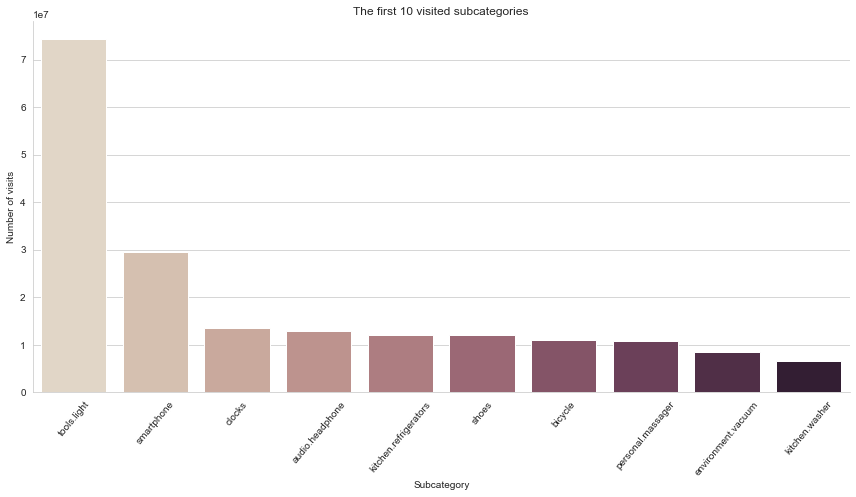

In [14]:
result_2_1 = hm.subcategory_visits(l)
hm.plot_RQ_2_1(result_2_1)

The concepts of category and subcategory were interpreted in this way: given the string corresponding to the category_code field, the category is the part of the string before the first ".", and the subcategory the part of the string after the first "."(e.g. : category_code = furniture.bedroom.bed; CAT = furniture , SUBCAT = bedroom.bed). We decided to show the 10 most visited subcategories for each category.


The plot shows the first ten visited subcategories in e-commerce in the last six months (Period October 2019-March 2020). The most visited sub-categories concern the technological field. This result can be commented in two different ways. The population most inclined to visit e-commerce sites has a great inclination to purchase technology for both work and leisure. The large number of visits of these sub-categories can also be justified by the continuous search by the customer towards the best price, continuously updated by the various e-commerce, which are involved in a real battle at the lowest price.

> ### **[RQ 2.2]** 
*What are the 10 most sold products per category?*

In this case, in order to understand all the categories, we have selected them based on the category_id, not presenting, unlike the category_code, missing fields.

In [17]:
result_2_2 = hm.number_of_purchases_for_category(l)
hm.RQ_2_2_format(result_2_2).head(10)

,category_code: 2053013551857008829,category_code: 2053013551865397438,category_code: 2053013551882174655,category_code: 2053013551890563264,category_code: 2053013551898951873,category_code: 2053013551907340482,category_code: 2053013551924117699,category_code: 2053013551932506308,category_code: 2053013551940894917,category_code: 2053013551966060743,...,category_code: 2232732135146389852,category_code: 2232732135213498718,category_code: 2232732135960084850,category_code: 2232732137285484952,category_code: 2232732137780412838,category_code: 2232732137855910312,category_code: 2232732138325672372,category_code: 2234185357446873711,category_code: 2282652065861730868,category_code: 2292044075982913587
0,100020872.0,57700005.0,60900000.0,59800004.0,13800225.0,18300021.0,20100131.0,12300108.0,3400071.0,41600018.0,...,100146168.0,100180583.0,100092245.0,100043555.0,100076383.0,100048333.0,100051521.0,100078988.0,100194399.0,100211867.0
1,100065133.0,57700012.0,60900001.0,NaN,13800414.0,18300155.0,100107373.0,100191960.0,3400149.0,41600014.0,...,100020082.0,100180582.0,100092080.0,100043504.0,100075415.0,100048398.0,100051598.0,100141024.0,100194323.0,100212136.0
2,100044930.0,57700001.0,NaN,NaN,13800165.0,18300141.0,100107181.0,100086813.0,NaN,100008084.0,...,100146140.0,100180573.0,100095224.0,100043549.0,100076465.0,100094939.0,100051618.0,100096204.0,100194457.0,100212298.0
3,100074707.0,57700003.0,NaN,NaN,13800084.0,18300496.0,100134539.0,28718098.0,NaN,41600016.0,...,100020495.0,100180574.0,100091989.0,100062179.0,100074709.0,100048390.0,NaN,100170456.0,NaN,100211574.0
4,100027840.0,57700006.0,NaN,NaN,13800029.0,18300184.0,100103911.0,100133665.0,NaN,41600015.0,...,100146203.0,100188503.0,100036031.0,100043507.0,100076376.0,100048328.0,NaN,100105865.0,NaN,100212277.0
5,100018715.0,57700008.0,NaN,NaN,13800030.0,18300825.0,100107183.0,100101300.0,NaN,100008270.0,...,100192488.0,100081955.0,100036073.0,100043545.0,100076464.0,100049663.0,NaN,100141023.0,NaN,100213408.0
6,100045430.0,57700002.0,NaN,NaN,13800011.0,18300738.0,100134226.0,100086789.0,NaN,41600019.0,...,100020474.0,100081902.0,100024911.0,100043551.0,100076466.0,100048336.0,NaN,100170457.0,NaN,100213439.0
7,100045398.0,57700007.0,NaN,NaN,13800004.0,18300917.0,100107204.0,100021381.0,NaN,41600021.0,...,100146214.0,100180575.0,100035270.0,100043557.0,100076987.0,100089921.0,NaN,100078992.0,NaN,100213456.0
8,100027251.0,57700017.0,NaN,NaN,13800038.0,18300214.0,100107217.0,28715607.0,NaN,7001177.0,...,100146193.0,100191709.0,100035787.0,100084048.0,100076396.0,100048383.0,NaN,100079008.0,NaN,NaN
9,100043352.0,57700000.0,NaN,NaN,13800113.0,18300456.0,100102468.0,28703603.0,NaN,100104983.0,...,100146149.0,100076600.0,100035789.0,NaN,100076430.0,100048395.0,NaN,100096199.0,NaN,NaN


________
# RQ3

*For each category, what’s the brand whose prices are higher on average?*


> ### **[RQ 3.1]**
*Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.*


As an example, we propose one result where by "category" we meant the category_code, and another example in which  by "category" we meant the category_id (our function accepts indiscriminately both types of input).

In [3]:
df_3_1_code = hm.RQ3_1(l)
df_3_1_code

Enter Category (ID or Code) furniture.living_room.sofa


,category_id,brand,mean_values
10001,2053013559792632471,aero,411.850000
10002,2053013559792632471,apriori,849.190000
10003,2053013559792632471,artengo,437.330000
10004,2053013559792632471,askona,1303.920000
10005,2053013559792632471,asm,601.998636
10006,2053013559792632471,bellamebel,1035.946667
10007,2053013559792632471,decathlon,611.082500
10008,2053013559792632471,defacto,10.273333
10009,2053013559792632471,divalux,932.226667
10010,2053013559792632471,embawood,818.530000


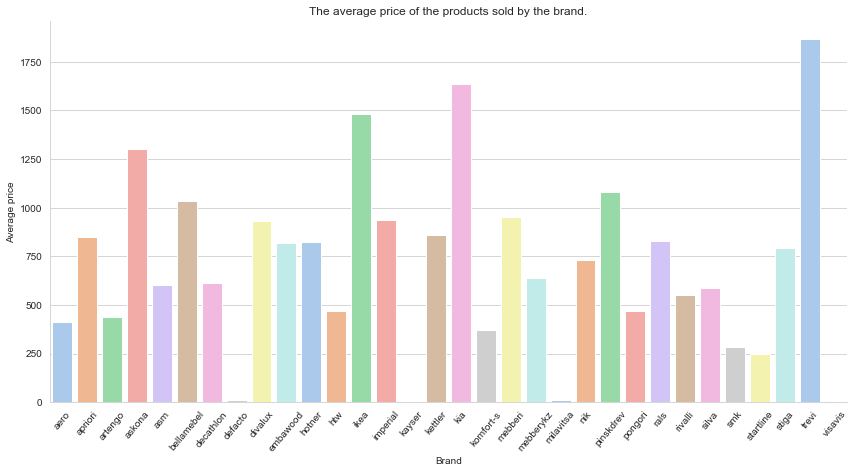

In [16]:
hm.plot_RQ3_1(df_3_1_code)

The plot shows the average price for the product sold by the brands of a specific category defined by us as input. The category choosen by us regard living room's sofa. This category is not included in the ten best-selling sub-categories analyzed above as it is associated with a limited niche of consumers. From the graph we can see a great variability in the average prices of the sofas offered by the various brands, this can be justified by the strategic choices made by the brand itself. Brands with high average prices (such as trevi, kia, ikea) may have focused on high quality, an excellent marketing job aiming at wealthy consumers. On the contrary, brands with an average price equal to half or even a quarter (airplane, artengo, etc. ..) may have decided on a different strategy aimed at satisfying the economic wishes of the customer even if offering a poor quality product or with poor advertising. 

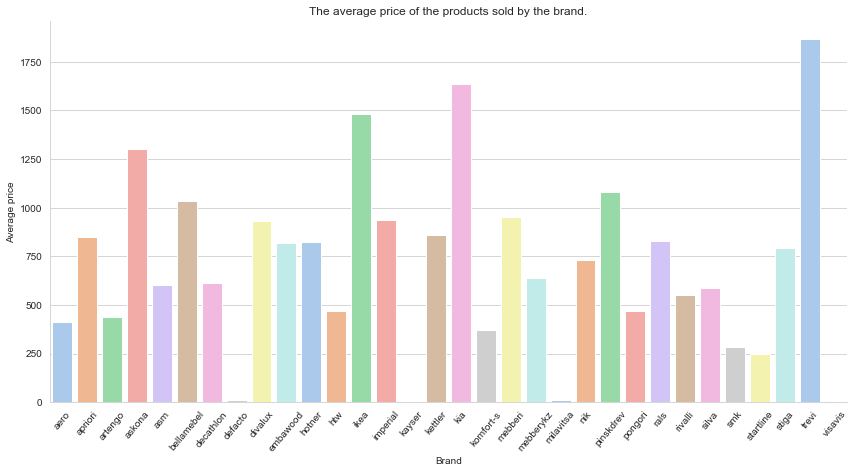

In [25]:
df_3_1_id = hm.RQ3_1(l)
hm.plot_RQ3_1(df_3_1_id)

This plot is obtained by entering the category ID and not the category code as done before. The category ID entered is 2053013559792632471 equal to the category code furniture.living_room.sofa. The plot obtained is the same as the previous one to confirm the functioning of the def both for category ID and for category_code

> ### **[RQ 3.2]**
*Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.*


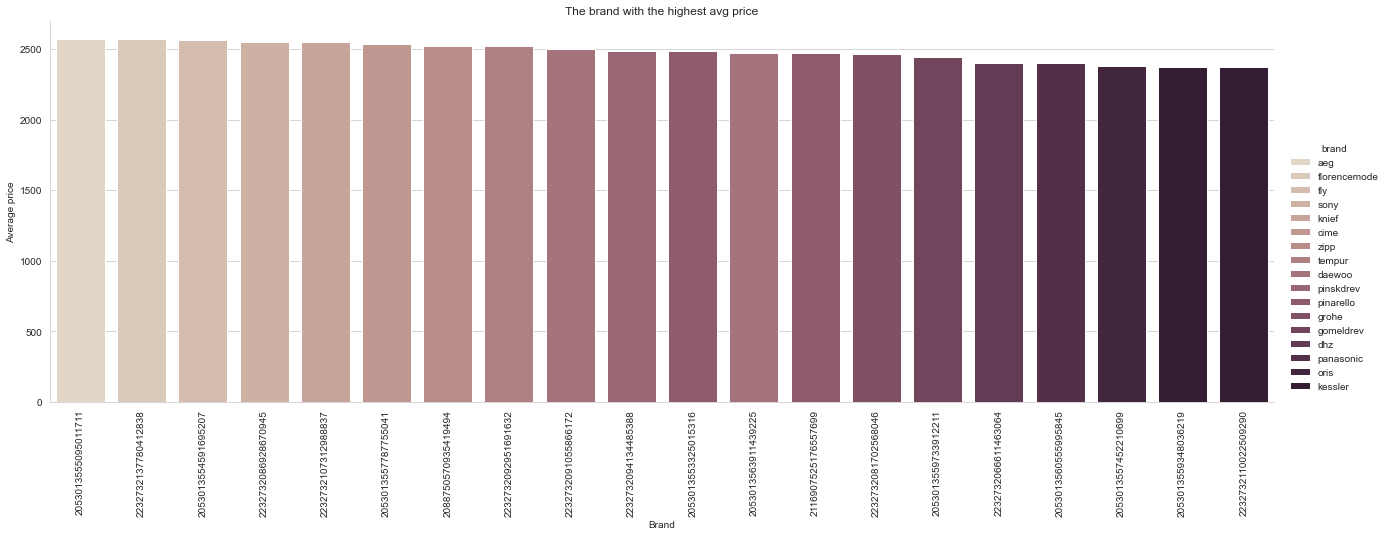

In [18]:
result_3_2 = hm.avgPrice_br_cat(l)
result_3_2 = hm.highest_avg_price(result_3_2).head(20)

hm.plot_RQ3_2(result_3_2)

The plot shows in descending order the brand for each category that has the highest average price. In the x axis we have placed the various category IDs while in the y axis the average price with a range between 0 and 2500. The color of each bar of the histogram is associated with a brand of each category ID In the representation we have decided to consider the first twenty categories to obtain a linear plot. There is a small maximum average price difference between each single category. He took the first twenty categories

________
# RQ4

*How much does each brand earn per month?*



> ### **[RQ 4.1]**
*Write a function that given the name of a brand in input returns, for each month, its profit. Is the average price of products of different brands significantly different?*

In [5]:
result_4_1 = hm.RQ_4_1(l)
result_4_1

,brand,Earnings of October,Earnings of November,Earnings of December,Earnings of January,Earnings of February,Earnings of March,Earnings of April
0,aqua,6336.63,7506.97,8729.48,4528.66,4962.88,3006.33,7074.38


> ### **[RQ 4.2]**
*Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing both the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).*

In [10]:
result_4_2_ = hm.RQ_4_2(l)
result_4_2_

,brand,loss,months
0,sportelite,68748.327004,January - February
1,matrol,37587.397134,December - January
2,blackberry,33314.607615,November - December


In [11]:
hm.string_biggest_loss(result_4_2_)

One of the biggest loss brand is "sportelite" with a loss  687.48 % during the period beetween January - February
One of the biggest loss brand is "matrol" with a loss  375.87 % during the period beetween December - January
One of the biggest loss brand is "blackberry" with a loss  333.15 % during the period beetween November - December


________
# RQ5


*In what part of the day is your store most visited? Knowing which days of the week or even which hours of the day shoppers are likely to visit your online store and make a purchase may help you improve your strategies. Create a plot that for each day of the week show the hourly average of visitors your store has.*

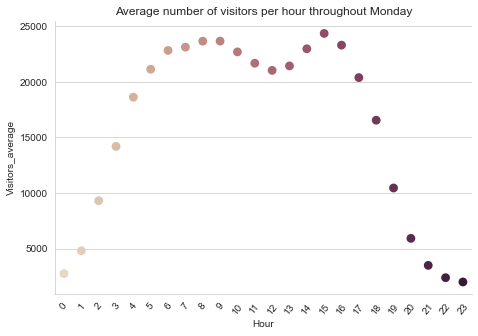

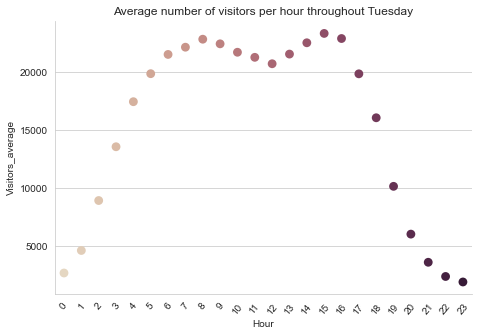

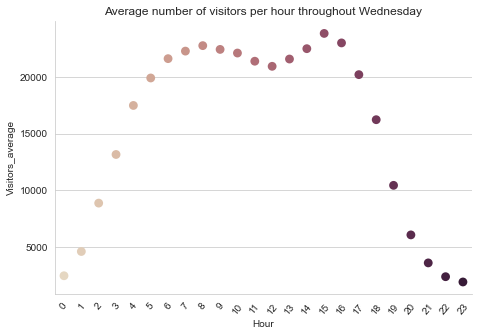

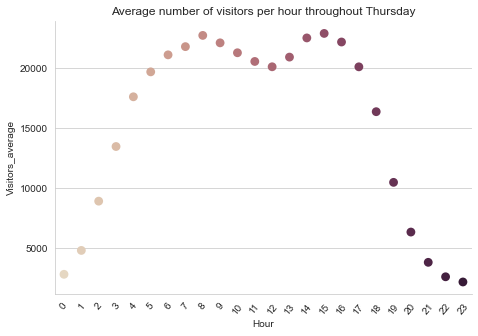

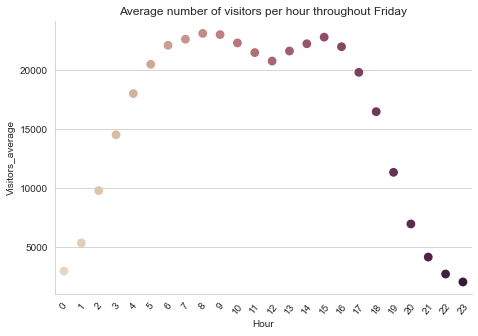

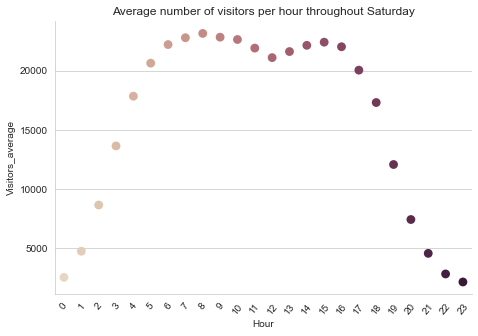

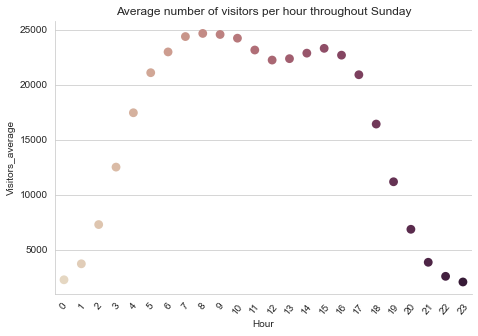

In [21]:
result_5 = hm.avg_visits_for_hour_for_dayweek(l)
hm.plot_RQ_5(result_5)

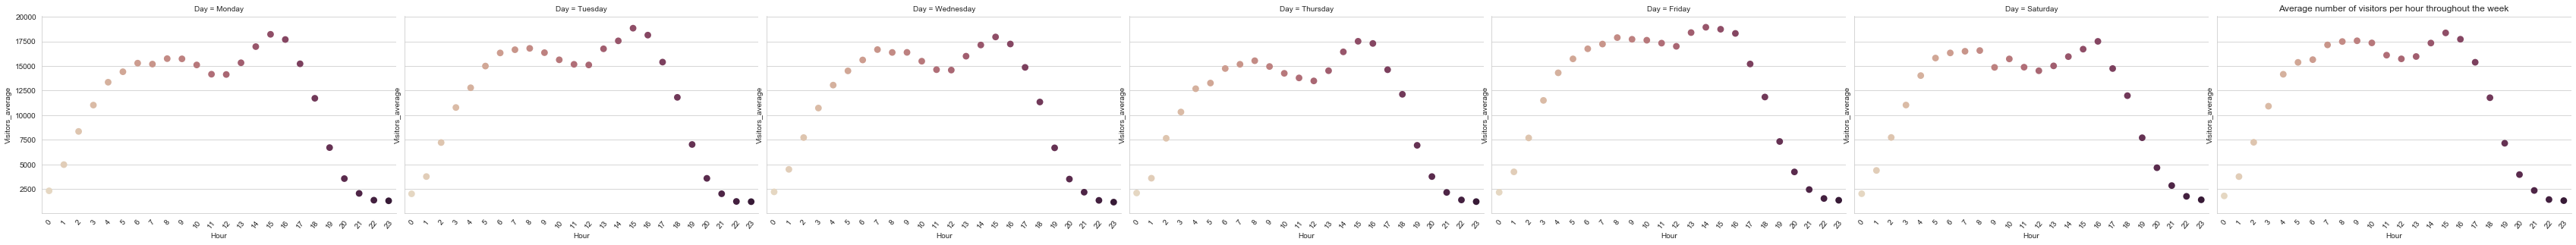

In [106]:
hm.plot2_RQ_5(result_5)

The plot shows the daily trend of the average number of visitors on e-commerce. We can see a mountain trend over the seven days that make up the week with small exceptions regarding the peak of visitors on weekdays and holidays. Analyzing the minimum of the graph (number of visits between 0 and 5000 per hour) it is possible to notice for all days of the week a match between night hours and this minimum peak. Regarding the maximum peak of the hourly visits (almost 25000 visits per hour) there is a small difference between the weekdays and holidays (Sunday). From Monday to Saturday the maximum peak is recorded in the pre-afternoon time (from 14pm to 16pm) while on Sunday the maximum peak is recorded in the early hours of the morning. This variation can be justified by the working hours of the average customer. The latter has free time during the week around lunchtime while on Sunday he is free from work.

___
# RQ6

*The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited. What's the conversion rate of your online store?*

>###  **[RQ 6.1]**
*Find the overall conversion rate of your store.*


The conversion rate for the e-commerce is a value beetween 0 and 1 because it's given by the number of times a product has been bought over th number of time it has been visited. The value that we define is very small. For this reason we can say that the number of purchases is much smaller respect the number of views. This aspect can be confirm by the plot of RQ 1.1 where the frequency of view is equal to 94% respect the frequency of purchase that is equal to 2%

In [22]:
result_6_1 = hm.prod_views_purchases(l)
hm.RQ_6_1(result_6_1)

0.017754711458446676

>###  **[RQ 6.2]**
*Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.*


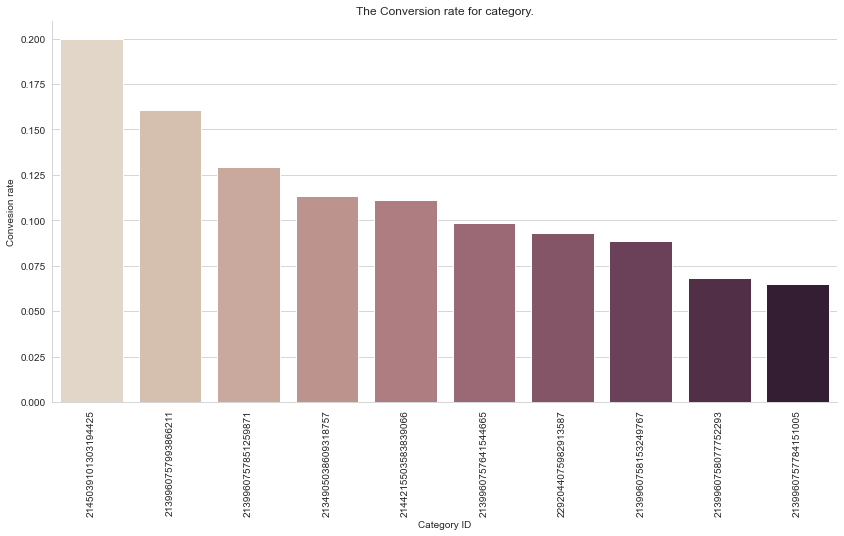

In [23]:
result_6_2 = hm.RQ_6_2(l)
hm.plot_RQ_6_2(hm.RQ_6_2(result_6_2).head(10))



The plot shows the conversion rate in decresee order for each categoty ID. The conversion rate is given by the number of times a product has been bought over the number of times it has been visited. Thil value must be equal or less than 1 as purchases always need a visit. From the graph we can verify this assumption is true in fact the maximum conversion rate is equal to 0.2. The conversion rate values for the various category ids vary between 0.05 to 0.2, this confirms that the choices of the customers do not determine a monopoly for the category IDs but on the contrary we find uniformity.

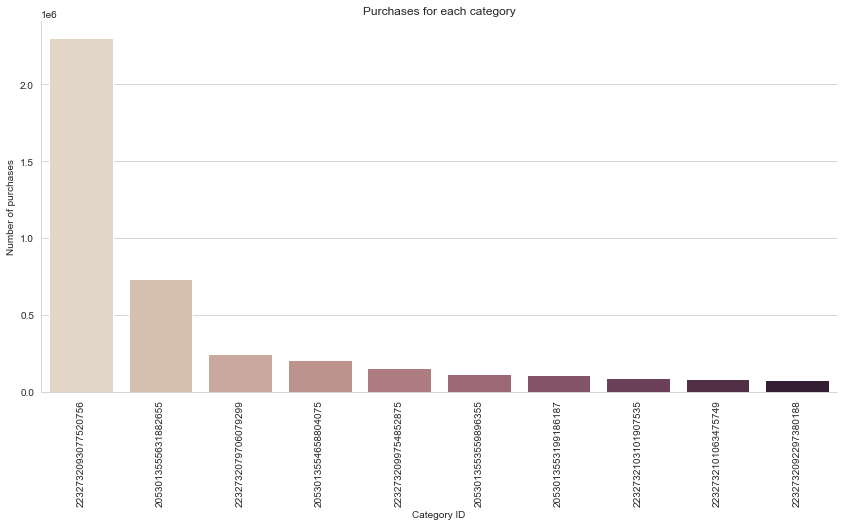

In [24]:
result_6_2_pfc = hm.purchases_for_category(l)
hm.plot2_RQ_6_2_pfc(result_6_2_pfc)



In the second plot created, we report for the entire period (October 2019-March 2020) the number of sales for each category belonging to e-commerce. The number of sales made is in the order of ten to sixth. This value is justified by the large period taken into consideration. The sales of the first category ID are approximately four times the sales of the second category ID. Important distance in sales also between the second category ID and the third. This distance flattens out starting from 3 category ID.

____
# RQ7
*The Pareto principle states that for many outcomes roughly 80% of consequences come from 20% of the causes. Also known as 80/20 rule, in e-commerce simply means that most of your business, around 80%, likely comes from about 20% of your customers.*

> ### **[RQ 7]**
*Prove that the pareto principle applies to your store.*


In [3]:
%%time
hm.RQ_7(l)

0
505152392.77007705
Wall time: 1min 20s


,user_id,user_purchase,cumulative_purchases,percentage_earnings,class
2191,512386086.0,344153.29,3.441533e+05,0.068129,A
113098,515384420.0,303144.24,6.472975e+05,0.128139,A
37773,513117637.0,266331.24,9.136288e+05,0.180862,A
197822,519267944.0,265569.52,1.179198e+06,0.233434,A
176885,518514099.0,203986.07,1.383184e+06,0.273815,A
...,...,...,...,...,...
336825,538224876.0,0.88,5.051524e+08,99.999999,B
161727,517557126.0,0.87,5.051524e+08,100.000000,B
252602,524830675.0,0.87,5.051524e+08,100.000000,B
48748,513378422.0,0.79,5.051524e+08,100.000000,B


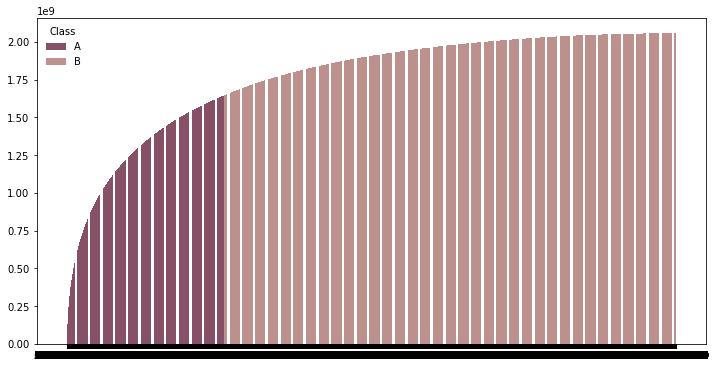

In [4]:
result_7 = hm.RQ_7(l)
hm.create_pareto_chart(result_7)

We have created the following plot to confirm Pareto's law with respect to purchases made in e-commerce. Not being able to report all the transactions in the graph, we decided to define pivotal transactions by taking one transaction out of 100. Even with this approximation, the pareto law (as we can see) is verified even if with a greater GAP between a transaction and the the other having sampled every 100 transactions. The graph shows the user IDs on the x axis and the cumulative purchases on the y axis. Furthermore, we can see a subdivision of the purchases made by user IDs into two classes (A, B) through a chromatic distinction. Class A represents the set of users (about 20%) who allow a purchase equal to 80% of the products sold. Class B represents the set of users who allow the acquisition of the remaining percentage of products sold. From this definition we can verify the effectiveness of the graph where few users define the cumulative purchase almost altogether (violet histograms) and the remaining user IDs (greater than those of class A) define the cumulative purchase missing (less than class A) .

In [4]:
hm.check_pareto(result_7)

number of class_A users : 533211
number of total users : 2064899
number of class_A users according Pareto :  412979
